# Diabetic Retinopathy Detection Using Python


Importing Nessesary libraries and modules from the local python environment

In [ ]:
from scipy import misc
from PIL import Image
from skimage import exposure
from sklearn import svm

import scipy
from math import sqrt,pi
from numpy import exp
from matplotlib import pyplot as plt
import numpy as np
import glob
import matplotlib.pyplot as pltss
import cv2
from matplotlib import cm
import pandas as pd
from math import pi, sqrt
import pywt
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from collections import Counter

In [ ]:
# Loading your drive so CoLab has access to it
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd '/content/drive/MyDrive/NN Final Project/aptos2019-blindness-detection/'

/content/drive/MyDrive/NN Final Project/aptos2019-blindness-detection


# Pre-processing

Loading Images and converting them to grey-Scale followed by adaptive hstogram equilisation
the final image matrix is stored in 1-D format to a new 2-D array

In [ ]:
train_df = pd.read_csv('train.csv')
print(f'No.of.training_samples: {len(train_df)}')
print(train_df['diagnosis'].value_counts())

No.of.training_samples: 3662
0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64


In [ ]:
immatrix=[]
Y = []

def load_data(m, n):
    for i in range(m):
      new_df = train_df[train_df['diagnosis'] == i]
      # print(new_df)
      for j in range(n):
        # print(j)
        
        image_id = new_df.iloc[j]['id_code']
        Y.append(i)
        img = cv2.imread(f'train_images/{image_id}.png')
        img = cv2.resize(img, (512, 512))
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        equ = cv2.equalizeHist(img_gray) 
        immatrix.append(np.array(equ).flatten())
        res = np.hstack((img_gray,equ))
        # print(np.shape(np.array(equ).flatten()))
    return equ

In [ ]:
equ = load_data(5, 150)

print(len(Y), Counter(Y))
np.shape(np.array(equ).flatten())

750 Counter({0: 150, 1: 150, 2: 150, 3: 150, 4: 150})


(262144,)

Visualising a random image after the above steps the array contains 90 images

The shape of the image is determined from np.shape(equ) and those values are 1152,1500

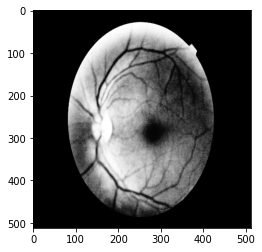

In [ ]:
np.shape(immatrix)
np.shape(equ)
plt.imshow(immatrix[78].reshape((512,512)),cmap='gray')
plt.show()

Performing Discrete-Wavelet transform on the 2-D array available

 the Haar wavelet is a sequence of rescaled "square-shaped" functions which together form a wavelet family or basis. Wavelet analysis is similar to Fourier analysis in that it allows a target function over an interval to be represented in terms of an orthonormal basis. The Haar sequence is now recognised as the first known wavelet basis and extensively used as a teaching example.

In [ ]:
imm_dwt = []
for equ in immatrix:
    equ = equ.reshape((512,512))
    coeffs = pywt.dwt2(equ, 'haar')
    equ2 = pywt.idwt2(coeffs, 'haar')
    imm_dwt.append(np.array(equ2).flatten())

Visualising a random image 

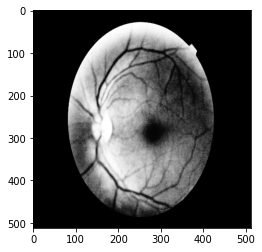

In [ ]:
np.shape(imm_dwt)
np.shape(equ2)
plt.imshow(imm_dwt[78].reshape((512,512)),cmap='gray')
plt.show()

In [ ]:
def _filter_kernel_mf_fdog(L, sigma, t = 3, mf = True):
    dim_y = int(L)
    dim_x = 2 * int(t * sigma)
    arr = np.zeros((dim_y, dim_x), 'f')
    
    ctr_x = dim_x / 2 
    ctr_y = int(dim_y / 2.)

    # an un-natural way to set elements of the array
    # to their x coordinate. 
    # x's are actually columns, so the first dimension of the iterator is used
    it = np.nditer(arr, flags=['multi_index'])
    while not it.finished:
        arr[it.multi_index] = it.multi_index[1] - ctr_x
        it.iternext()

    two_sigma_sq = 2 * sigma * sigma
    sqrt_w_pi_sigma = 1. / (sqrt(2 * pi) * sigma)
    if not mf:
        sqrt_w_pi_sigma = sqrt_w_pi_sigma / sigma ** 2

    #@vectorize(['float32(float32)'], target='cpu')
    def k_fun(x):
        return sqrt_w_pi_sigma * exp(-x * x / two_sigma_sq)

    #@vectorize(['float32(float32)'], target='cpu')
    def k_fun_derivative(x):
        return -x * sqrt_w_pi_sigma * exp(-x * x / two_sigma_sq)

    if mf:
        kernel = k_fun(arr)
        kernel = kernel - kernel.mean()
    else:
        kernel = k_fun_derivative(arr)

    # return the "convolution" kernel for filter2D
    return cv2.flip(kernel, -1) 

def show_images(images,titles=None, scale=1.3):
    """Display a list of images"""
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n) # Make subplot
        if image.ndim == 2: # Is image grayscale?
            plt.imshow(image, cmap = cm.Greys_r)
        else:
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        a.set_title(title)
        plt.axis("off")
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches(), dtype=np.float) * n_ims / scale)
    plt.show()


def gaussian_matched_filter_kernel(L, sigma, t = 3):
    '''
    K =  1/(sqrt(2 * pi) * sigma ) * exp(-x^2/2sigma^2), |y| <= L/2, |x| < s * t
    '''
    return _filter_kernel_mf_fdog(L, sigma, t, True)

#Creating a matched filter bank using the kernel generated from the above functions
def createMatchedFilterBank(K, n = 12):
    rotate = 180 / n
    center = (K.shape[1] / 2, K.shape[0] / 2)
    cur_rot = 0
    kernels = [K]

    for i in range(1, n):
        cur_rot += rotate
        r_mat = cv2.getRotationMatrix2D(center, cur_rot, 1)
        k = cv2.warpAffine(K, r_mat, (K.shape[1], K.shape[0]))
        kernels.append(k)

    return kernels

#Given a filter bank, apply them and record maximum response

def applyFilters(im, kernels):

    images = np.array([cv2.filter2D(im, -1, k) for k in kernels])
    return np.max(images, 0)


gf = gaussian_matched_filter_kernel(20, 5)
bank_gf = createMatchedFilterBank(gf, 4)

imm_gauss = []
for equ2 in imm_dwt:
    equ2 = equ2.reshape((512,512))
    equ3 = applyFilters(equ2,bank_gf)
    imm_gauss.append(np.array(equ3).flatten())

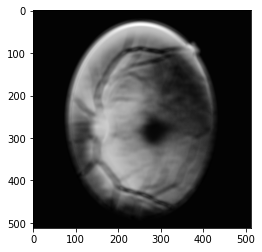

In [ ]:
# the array ranges from 0 - 89
np.shape(imm_gauss)
plt.imshow(imm_gauss[78].reshape((512,512)),cmap='gray')
plt.show()

In [ ]:
def createMatchedFilterBank():
    filters = []
    ksize = 31
    for theta in np.arange(0, np.pi, np.pi / 16):
        kern = cv2.getGaborKernel((ksize, ksize), 6, theta,12, 0.37, 0, ktype=cv2.CV_32F)
        kern /= 1.5*kern.sum()
        filters.append(kern)
    return filters

def applyFilters(im, kernels):
    images = np.array([cv2.filter2D(im, -1, k) for k in kernels])
    return np.max(images, 0)

bank_gf = createMatchedFilterBank()
#equx=equ3
#equ3 = applyFilters(equ2,bank_gf)
imm_gauss2 = []
for equ2 in imm_dwt:
    equ2 = equ2.reshape((512,512))
    equ3 = applyFilters(equ2,bank_gf)
    imm_gauss2.append(np.array(equ3).flatten())

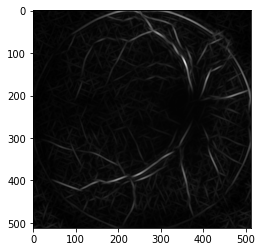

In [ ]:
# the array ranges from 0 - 89
np.shape(imm_gauss2)
plt.imshow(imm_gauss2[20].reshape((512,512)),cmap='gray')
plt.show()

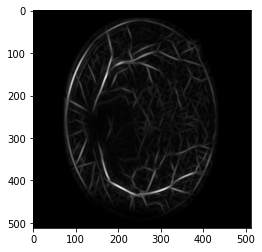

In [ ]:
# the array ranges from 0 - 89
np.shape(imm_gauss2)
plt.imshow(imm_gauss2[1].reshape((512,512)),cmap='gray')
plt.show()

In [ ]:
e_ = equ3
np.shape(e_)
e_=e_.reshape((-1,2))
np.shape(e_)

(131072, 2)

Performing K-means Clusttering with PP centers(non random) neighbours on the final image

In [ ]:
img = equ3
Z = img.reshape((-1,2))

# convert to np.float32
Z = np.float32(Z)

k=cv2.KMEANS_PP_CENTERS


# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,k)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))

In [ ]:
imm_kmean = []
for equ3 in imm_gauss2:
    img = equ3.reshape((512,512))
    Z = img.reshape((-1,2))

    # convert to np.float32
    Z = np.float32(Z)

    k=cv2.KMEANS_PP_CENTERS


    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,k)

    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))
    imm_kmean.append(np.array(res2).flatten())



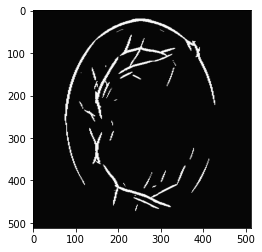

In [ ]:
# the array ranges from 0 - 89
np.shape(imm_kmean)
plt.imshow(imm_kmean[78].reshape((512,512)),cmap="gray")
plt.show()

# Model training

Importing SVc(same as SVM) from sklearn library

In [ ]:
from sklearn.svm import SVC
clf = SVC()

These corresponding Images are marked as non-effected in the data-set

SVM with Radial Basis Function (RBF)

Linear SVM classifies the data by putting a hyper plane between the two classes. In the case of rbf SVM the plane would be in infinite dimension

In [ ]:
clf.fit(imm_kmean, Y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
immatrix=[]
Y = []

def load_data(m, n):
    for i in range(m):
      new_df = train_df[train_df['diagnosis'] == i]
      for j in range(n):
        # print(j)
        image_id = new_df.iloc[150 + j]['id_code']
        Y.append(i)
        img = cv2.imread(f'train_images/{image_id}.png')
        img = cv2.resize(img, (512, 512))
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        equ = cv2.equalizeHist(img_gray) 
        immatrix.append(np.array(equ).flatten())
        res = np.hstack((img_gray,equ))
        # print(np.shape(np.array(equ).flatten()))
    return equ

In [ ]:
equ = load_data(5, 40)

print(len(Y), Counter(Y))
np.shape(np.array(equ).flatten())

200 Counter({0: 40, 1: 40, 2: 40, 3: 40, 4: 40})


(262144,)

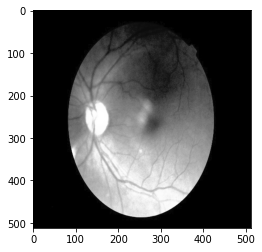

In [ ]:
np.shape(immatrix)
np.shape(equ)
plt.imshow(immatrix[12].reshape((512,512)),cmap='gray')
plt.show()

In [ ]:
imm_dwt = []
for equ in immatrix:
    equ = equ.reshape((512,512))
    coeffs = pywt.dwt2(equ, 'haar')
    equ2 = pywt.idwt2(coeffs, 'haar')
    imm_dwt.append(np.array(equ2).flatten())

In [ ]:
bank_gf = createMatchedFilterBank()
#equx=equ3
#equ3 = applyFilters(equ2,bank_gf)
imm_gauss2 = []
for equ2 in imm_dwt:
    equ2 = equ2.reshape((512,512))
    equ3 = applyFilters(equ2,bank_gf)
    imm_gauss2.append(np.array(equ3).flatten())

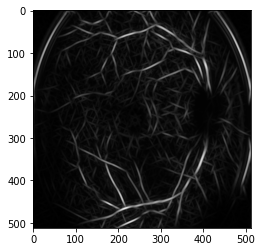

In [ ]:
# the array ranges from 0 - 89
np.shape(imm_gauss2)
plt.imshow(imm_gauss2[20].reshape((512,512)),cmap='gray')
plt.show()

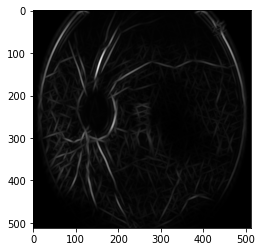

In [ ]:
# the array ranges from 0 - 89
np.shape(imm_gauss2)
plt.imshow(imm_gauss2[1].reshape((512,512)),cmap='gray')
plt.show()

In [ ]:
e_ = equ3
np.shape(e_)
e_=e_.reshape((-1,2))
np.shape(e_)

(131072, 2)

In [ ]:
img = equ3
Z = img.reshape((-1,2))

# convert to np.float32
Z = np.float32(Z)

k=cv2.KMEANS_PP_CENTERS


# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,k)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))

In [ ]:
imm_kmean = []
for equ3 in imm_gauss2:
    img = equ3.reshape((512,512))
    Z = img.reshape((-1,2))

    # convert to np.float32
    Z = np.float32(Z)

    k=cv2.KMEANS_PP_CENTERS


    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,k)

    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))
    imm_kmean.append(np.array(res2).flatten())

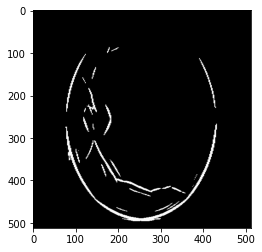

In [ ]:
# the array ranges from 0 - 89
np.shape(imm_kmean)
plt.imshow(imm_kmean[12].reshape((512,512)),cmap="gray")
plt.show()

In [ ]:
y_pred = clf.predict(imm_kmean)

In [ ]:
target_names = ['Normal', 'Mild', 'Moderate', 'Severe', 'Proliferative']

print(classification_report(Y, y_pred, target_names=target_names))

               precision    recall  f1-score   support

       Normal       0.34      0.45      0.39        40
         Mild       0.23      0.17      0.20        40
     Moderate       0.12      0.07      0.09        40
       Severe       0.16      0.12      0.14        40
Proliferative       0.25      0.38      0.30        40

     accuracy                           0.24       200
    macro avg       0.22      0.24      0.22       200
 weighted avg       0.22      0.24      0.22       200



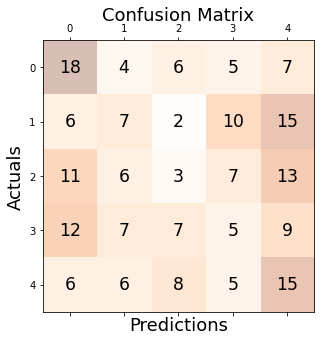

In [ ]:
conf_matrix = confusion_matrix(y_true=Y, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.savefig('Confusion Matrixfor SVC')
plt.show()